Installing necessary packges

In [ ]:
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Importing packages and importing the MNIST dataset using the datasets package

In [4]:
from datasets import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
dataset = load_dataset("mnist", split = "train")

In [6]:
df = pd.DataFrame(dataset)
print(len(df))

60000


# Vectorize images
The Image in the dataset is converted into a 28x28 matrix and then flattened to a 784x1 vector.

In [11]:
n = 60000
d = 784
X = np.zeros((n, d))

for i in range(n):
  m = np.array(df.iloc[i,0])
  m = np.matrix(m)
  X[i] = np.array(m.flatten())


print(np.shape(X))
mean = np.mean(X, axis = 0)
X_centered = X - np.mean(X, axis = 0)
X_centered = X_centered.T
C = np.cov(X_centered) #Covariance matrix


(60000, 784)


In [ ]:
print(df.iloc[0,1])

7


Eigen vector computation

In [8]:
def eig_sorted(M):
  v, w = np.linalg.eig(M)
  idx = v.argsort()[::-1]
  v = v[idx]
  w = w[:,idx]
  return v,w

Top K eigen vectors of C

In [14]:
eigval, eigvect = eig_sorted(C)
def reconstruct(k):
  w_k = eigvect[:,0:k]
  P = w_k @ w_k.T
  reconstruction = P @ X_centered
  reconstruction = reconstruction.T
  reconstruction = reconstruction + mean
  reconstruction =reconstruction.T
  reconstruction = reconstruction.real
  return reconstruction

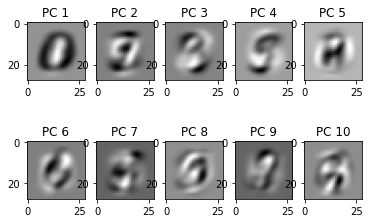

In [13]:
n_pc = 10
for i in range(n_pc):
  plt.subplot(2,5,i+1)
  plt.imshow(eigvect[:,i].reshape((28,28)), cmap = 'gray')
  plt.title("PC %d" %(i+1)) 

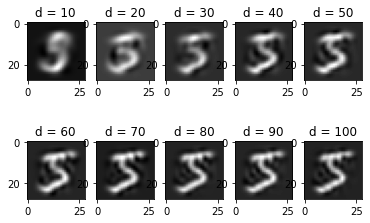

In [15]:
for i in range(10):
  rec = reconstruct((i+1)*10)
  plt.subplot(2,5,i+1)
  
  plt.imshow(rec[:,0].reshape((28,28)), cmap = "gray")
  plt.title("d = %d" %((i+1)*10))

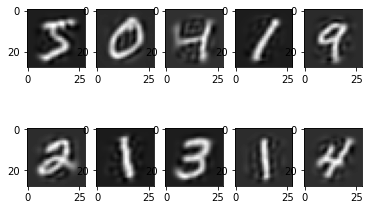

In [16]:
rec = reconstruct(70)
for i in range(10):
  plt.subplot(2,5,i+1)
  plt.imshow(rec[:,i].reshape((28,28)), cmap = "gray")

#1.3 Kernel PCA
##A. Kernel (1 + xTy)^d




In [18]:
def rbf_kernel(M, gamma):
  n = M.shape[1]
  sq_dist = np.zeros((n,n))
  one = (1/n)*np.ones((n,n))
  for i in range(n):
    for j in range(i,n):
      x_i = M[:,i]
      y_i = M[:,j]
      sq_dist[i][j] = (np.linalg.norm(x_i - y_i))**2
      sq_dist[j][i] = sq_dist[i][j]
  Kernel = np.exp(-gamma*sq_dist)
  Kernel = Kernel - one.dot(Kernel) - Kernel.dot(one) + one.dot(Kernel).dot(one)
  return Kernel

In [12]:
def poly_kernel(M, p):
  n = M.shape[1]
  one = (1/n)*np.ones((n,n))
  K = np.zeros((n,n))
  for i in range(n):
    for j in range(i,n):
      x = M[:,i]
      y = M[:,j]
      K[i][j] = (1 + x.dot(y))**p
      K[j][i] = (1 + x.dot(y))**p
  K = K - one.dot(K) - K.dot(one) + one.dot(K).dot(one)
  return K

[[-0.27769463  0.83110434]
 [-0.03922054 -1.40058384]
 [-2.1433765  -0.77847133]
 ...
 [ 1.75386662 -1.19540719]
 [ 1.20231441  0.35071951]
 [ 0.35333285  1.61529654]]


Text(0, 0.5, 'PC 2')

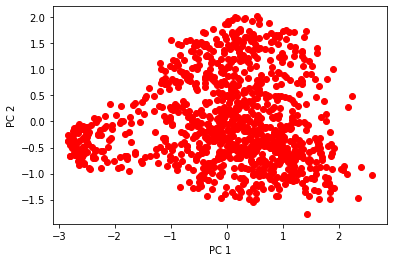

In [47]:
X_norm = X.T / np.linalg.norm(X.T, axis = 0)
K = rbf_kernel(X_norm.T, 1)
n_comp = 2
eigv, eigvect = eig_sorted(K)
w = eigvect[:, :n_comp]
X_kpca = K @ w
X_kpca = X_kpca.real

print(X_kpca)
for i in range(n):
  plt.scatter(X_kpca[i, 0], X_kpca[i, 1], c = 'r')
plt.xlabel('PC 1')
plt.ylabel('PC 2')

In [ ]:
first_image = reconstruction[:,0].reshape((28,28))
im = Image.fromarray(first_image.astype(np.uint8))
im.show()
display(im.resize((100,100)))

# 2.1 K-Means Clustering


            x         y
0    -1.20610  -2.52680
1    -3.70380   0.33831
2     4.34440   0.96302
3     3.36140   2.94250
4     4.11750   2.15120
..        ...       ...
995   4.95430 -10.04200
996  -0.65809 -14.25900
997  -2.84580 -14.46900
998 -11.17300  -7.40880
999  -2.38570 -13.21200

[1000 rows x 2 columns]


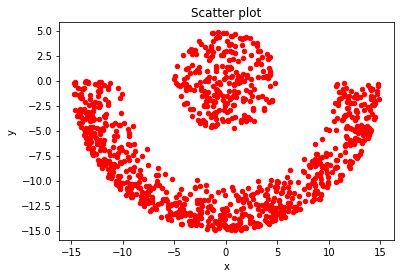

In [111]:
from google.colab import files
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt
import random
import math
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.cluster import SpectralClustering
df = pd.read_csv('https://raw.githubusercontent.com/GaneshDev2003/PRML-Assignment-1/main/cm_dataset_2.csv')
df2 = pd.concat([pd.DataFrame({'-1.2061': -1.2061,'-2.5268':-2.5268 }, index = [0]), df.loc[:]]).reset_index(drop = True)

df2.columns = ['x', 'y']
print(df2)

df2.plot(kind = 'scatter', x = 'x', y = 'y', color = 'red')
plt.title('Scatter plot')
plt.show()

In [136]:
k = 2
n = 1000

In [24]:
def compute_mean(x, z):
  mean = np.zeros((k,2))
  count = np.zeros((k,1))
  for i in range(len(x)):
    mean[(int)(z[i][0])-1] += x[i]
    count[(int)(z[i][0])-1] += 1
  for j in range(k):
    mean[j] = mean[j]/count[j]
  #print(count)
  return mean

In [25]:
def find_best_cluster(x,z,mean):
  new_z = np.zeros((1000,1))
  for i in range(n):
    new_z[i] = np.argmin([np.linalg.norm(x[i]-mu) for mu in mean]) + 1
  return new_z

In [26]:
def cost_function(x,z,mean):
  cost = 0
  for i in range(n):
    cost += np.linalg.norm(x[i]-mean[(int)(z[i][0])-1])**2
  return cost

In [167]:
def lloyd_algo(x):
  z = np.zeros((1000,1))
  re_z = np.zeros((1000,1))
  cost_iteration = []

  mean = random.sample([x_i for x_i in x], k)
  mean_re = random.sample([x_i for x_i in x], k)
  print(mean_re)
  print(np.array_equal(z,re_z))

  while(not np.array_equal(mean, mean_re)):
    mean = mean_re
    z = find_best_cluster(x, z, mean)
    mean_re = compute_mean(x,z)
    cost_iteration.append(cost_function(x,z,mean_re))
  plt.plot(cost_iteration)
  plt.ylabel('error function')
  plt.xlabel('iteration')
  plt.show()
  print(mean)
  return z,mean

[array([-7.42380474, -6.19442195]), array([-8.38280474, -2.22252195])]
True


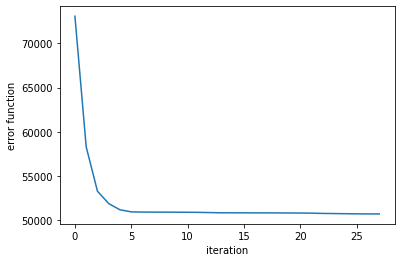

[[ 6.74397109 -0.08729112]
 [-6.90779225  0.08941155]]


Text(0, 0.5, 'feature 2')

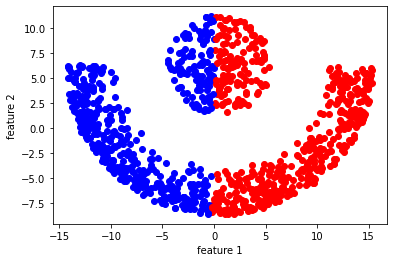

In [172]:
x = df2.to_numpy()
x = x - np.mean(x, axis =0)
z, mean = lloyd_algo(x)
color = ['r', 'b', 'c', 'g', 'y']
for i in range(n):
  plt.scatter(x[i][0], x[i][1], c = color[(int)(z[i])-1])
plt.xlabel('feature 1')
plt.ylabel('feature 2')

In [116]:
def voronoi(x, means, labels): 
  for k in range(means.shape[0]):
    for i in range(n):
      plt.scatter(x[i][0], x[i][1], c = color[(int)(z[i])-1])
    x_min= x[:, 0].min()- 1 
    x_max= x[:, 0].max() + 1
    y_min= x[:, 1].min() - 1
    y_max = x[:,1].max() + 1
    print(y_max)

    xx, yy = np.meshgrid (np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
    Z= np.argmin(np.sqrt(((np.c_[xx.flatten(), yy.flatten()] - means[:, np.newaxis])**2).sum(axis=2)), axis=0)
    Z = Z.reshape(xx.shape)
    plt.imshow(Z, extent=(xx.min(),xx.max(),yy.min(),yy.max()), alpha = 0.1)
  plt.title('Voronoi regions')
  plt.show()

12.20437804867
12.20437804867
12.20437804867
12.20437804867
12.20437804867


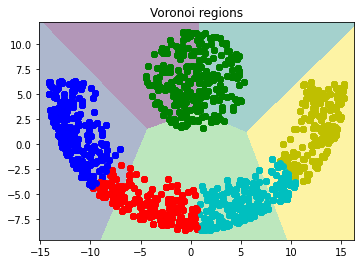

In [133]:
voronoi(x, mean, z)

# 2.2 Spectral Clustering using RBF Kernel

[[ 0.11527716 -0.99333337]
 [ 0.29289401 -0.95614491]
 [-0.39331202 -0.91940506]
 ...
 [ 0.18352336  0.98301535]
 [ 0.98906988  0.14744755]
 [ 0.17475262  0.98461237]]


Text(0, 0.5, 'feature 2')

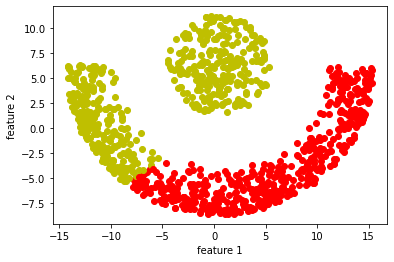

In [153]:
K = rbf_kernel(x.T, 1e-7)
eigvalues, eigvectors = np.linalg.eig(K)

idx = eigvalues.argsort()[::-1]
eigvalues = eigvalues[idx]
eigvectors = eigvectors[:,idx]

H = eigvectors[:,:k]
H = H.real
for i in range(H.shape[0]):
  H[i] = H[i]/np.linalg.norm(H[i])
print(H)
z_kernel2 = np.argmax(H, axis = 1)

color = ['r', 'b', 'c', 'g', 'y']
for i in range(n):
  plt.scatter(x[i][0], x[i][1], c = color[(int)(z_kernel2[i])-1])
plt.xlabel('feature 1')
plt.ylabel('feature 2')